# Wing Aerodynamics Analysis using Vortex-Step Method (VSM) on a LEI Kite
This notebook demonstrates the process of setting up and analyzing a wing's aerodynamics using VSM on a LEI Kite. We'll cover the following steps:
1. Setting up the environment and importing necessary libraries.
2. Creating a wing object and adding sections to define the geometry from a CSV file.
3. Initializing the wing aerodynamics and set the inflow conditions.
4. Plotting 

## 1. Import necessary libraries
In this step, we import the necessary libraries for the aerodynamic analysis. We use:
- `numpy` for numerical operations.
- The `VSM` module for the aerodynamic modelling

Make sure the `VSM` module is properly installed in your (virtual) environment, by running the cmd: `pip install -e .` from the root-directory of this project

In [10]:
import numpy as np
import logging
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
from VSM.WingGeometry import Wing
from VSM.WingAerodynamics import WingAerodynamics
from VSM.Solver import Solver
from VSM.plotting import plot_polars, plot_distribution, plot_geometry

## 2. Creating a wing object and adding sections to define the geometry from a CSV file.

In [12]:
# Find the root directory of the repository
root_dir = os.getcwd()
while not os.path.isfile(os.path.join(root_dir, ".gitignore")):
    root_dir = os.path.abspath(os.path.join(root_dir, ".."))
    if root_dir == "/":
        raise FileNotFoundError("Could not find the root directory of the repository.")
save_folder = Path(root_dir) / "results" / "TUDELFT_V3_LEI_KITE"

# Defining discretisation
n_panels = 54
spanwise_panel_distribution = "split_provided"

### rib_list_from_CAD_LE_TE_and_surfplan_d_tube_camber_19ribs
csv_file_path = (
    Path(root_dir)
    / "processed_data"
    / "TUDELFT_V3_LEI_KITE"
    / "rib_list_from_CAD_LE_TE_and_surfplan_d_tube_camber_19ribs.csv"
)
(
    LE_x_array,
    LE_y_array,
    LE_z_array,
    TE_x_array,
    TE_y_array,
    TE_z_array,
    d_tube_array,
    camber_array,
) = np.loadtxt(csv_file_path, delimiter=",", skiprows=1, unpack=True)
rib_list_from_CAD_LE_TE_and_surfplan_d_tube_camber_19ribs = []
for i in range(len(LE_x_array)):
    LE = np.array([LE_x_array[i], LE_y_array[i], LE_z_array[i]])
    TE = np.array([TE_x_array[i], TE_y_array[i], TE_z_array[i]])
    rib_list_from_CAD_LE_TE_and_surfplan_d_tube_camber_19ribs.append(
        [LE, TE, ["lei_airfoil_breukels", [d_tube_array[i], camber_array[i]]]]
    )
CAD_wing = Wing(n_panels, spanwise_panel_distribution)

for i, CAD_rib_i in enumerate(
    rib_list_from_CAD_LE_TE_and_surfplan_d_tube_camber_19ribs
):
    CAD_wing.add_section(CAD_rib_i[0], CAD_rib_i[1], CAD_rib_i[2])
wing_aero_CAD_19ribs = WingAerodynamics([CAD_wing])


## 3. Initializing the wing aerodynamics and set the inflow conditions.

In [15]:
# Solvers
VSM = Solver(
    aerodynamic_model_type="VSM",
    is_with_artificial_damping=False,
)
VSM_with_stall_correction = Solver(
    aerodynamic_model_type="VSM",
    is_with_artificial_damping=True,
)

# setting va
Umag = 15
aoa = 17
side_slip = 0
yaw_rate = 0
aoa_rad = np.deg2rad(aoa)
vel_app = (
    np.array(
        [
            np.cos(aoa_rad) * np.cos(side_slip),
            np.sin(side_slip),
            np.sin(aoa_rad),
        ]
    )
    * Umag
)
wing_aero_CAD_19ribs.va = (vel_app, yaw_rate)



## 4. Plotting 

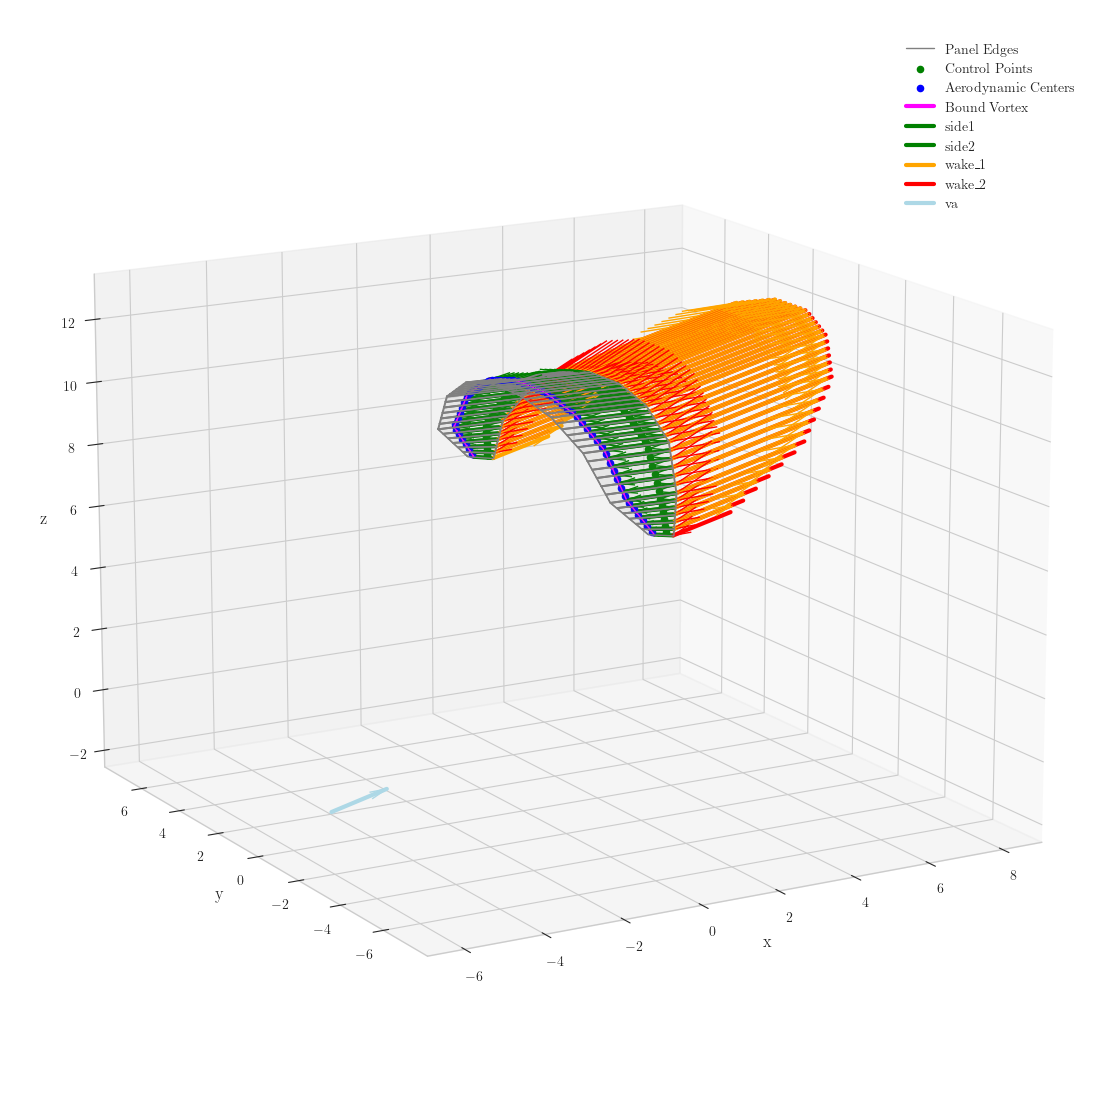

INFO:root:Converged after 191 iterations
INFO:root:Converged after 199 iterations


OSError: [WinError -2147221164] Classe non enregistrée: 'C:\\Users\\RomainLambert\\AppData\\Local\\Temp\\tmp1und_hg_.png'

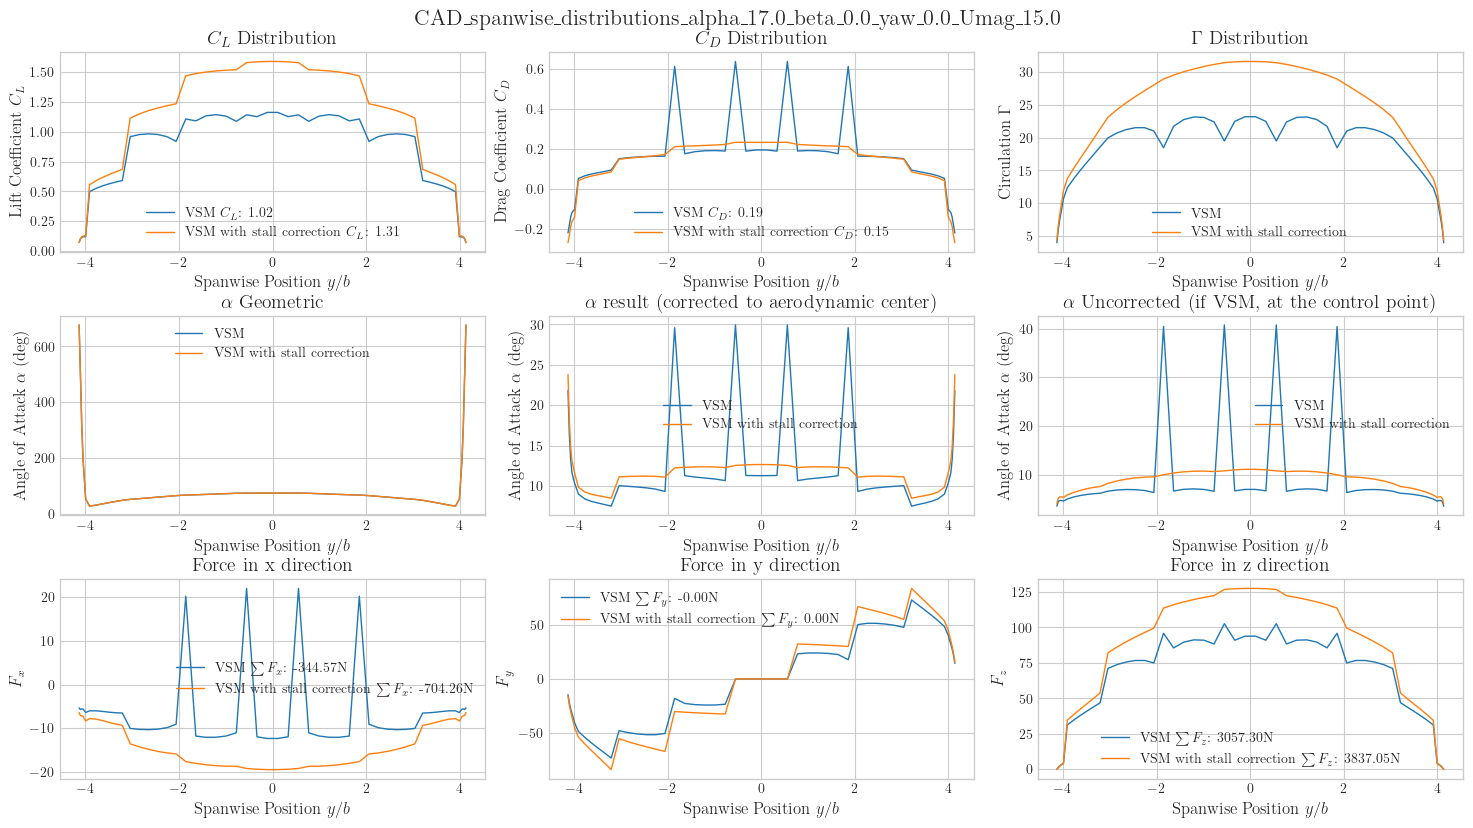

In [16]:
## Plotting
plot_geometry(
    wing_aero_CAD_19ribs,
    title=" ",
    data_type=".svg",
    save_path=" ",
    is_save=False,
    is_show=True,
    view_elevation=15,
    view_azimuth=-120,
)

### plotting distributions
results = VSM.solve(wing_aero_CAD_19ribs)
results_with_stall_correction = VSM_with_stall_correction.solve(wing_aero_CAD_19ribs)
CAD_y_coordinates = [
    panels.aerodynamic_center[1] for panels in wing_aero_CAD_19ribs.panels
]
plot_distribution(
    y_coordinates_list=[CAD_y_coordinates, CAD_y_coordinates],
    results_list=[results, results_with_stall_correction],
    label_list=["VSM", "VSM with stall correction"],
    title=f"CAD_spanwise_distributions_alpha_{aoa:.1f}_beta_{side_slip:.1f}_yaw_{yaw_rate:.1f}_Umag_{Umag:.1f}",
    data_type=".pdf",
    save_path=Path(save_folder) / "spanwise_distributions",
    is_save=False,
    is_show=True,
)

### plotting polar
save_path = Path(root_dir) / "results" / "TUD_V3_LEI_KITE"
path_cfd_lebesque = (
    Path(root_dir)
    / "data"
    / "TUDELFT_V3_LEI_KITE"
    / "literature_results"
    / "V3_CL_CD_RANS_Lebesque_2024_Rey_300e4.csv"
)

plot_polars(
    solver_list=[VSM, VSM_with_stall_correction],
    wing_aero_list=[
        wing_aero_CAD_19ribs,
        wing_aero_CAD_19ribs,
    ],
    label_list=[
        "VSM CAD 19ribs",
        "VSM CAD 19ribs , with stall correction",
        "CFD_Lebesque Rey 30e5",
    ],
    literature_path_list=[path_cfd_lebesque],
    angle_range=np.linspace(0, 25, 25),
    angle_type="angle_of_attack",
    angle_of_attack=0,
    side_slip=0,
    yaw_rate=0,
    Umag=10,
    title=f"tutorial_testing_stall_model_n_panels_{int(n_panels):.0f}_distribution_{spanwise_panel_distribution}",
    data_type=".pdf",
    save_path=Path(save_folder) / "polars",
    is_save=True,
    is_show=True,
)
